In [0]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [0]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random

In [0]:
np.random.seed(0)

In [0]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
#
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)
#
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)

print(train_data)
X_train, y_train = train_data['features'], train_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
X_val, y_val = val_data['features'], val_data['labels']

{'coords': array([[  6,   5,  21,  20],
       [  6,   6,  22,  22],
       [  5,   6,  22,  23],
       ...,
       [ 17,  15, 178, 155],
       [ 17,  15, 183, 160],
       [ 20,  18, 211, 184]], dtype=uint8), 'labels': array([41, 41, 41, ..., 25, 25, 25], dtype=uint8), 'features': array([[[[ 28,  25,  24],
         [ 27,  24,  23],
         [ 27,  24,  22],
         ...,
         [ 32,  28,  24],
         [ 31,  27,  25],
         [ 31,  27,  26]],

        [[ 29,  26,  25],
         [ 27,  25,  23],
         [ 27,  25,  23],
         ...,
         [ 32,  28,  24],
         [ 31,  27,  24],
         [ 30,  27,  25]],

        [[ 28,  26,  26],
         [ 27,  25,  23],
         [ 26,  25,  23],
         ...,
         [ 32,  28,  24],
         [ 31,  27,  24],
         [ 30,  27,  25]],

        ...,

        [[ 27,  24,  23],
         [ 28,  25,  24],
         [ 30,  25,  24],
         ...,
         [ 27,  24,  23],
         [ 28,  24,  22],
         [ 29,  25,  22]],

        [[ 28

In [0]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [0]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"

assert(X_train.shape[1:] == (32, 32, 3)), "The dimesions of the images are not 32, 32, 3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimesions of the images are not 32, 32, 3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimesions of the images are not 32, 32, 3"

In [0]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

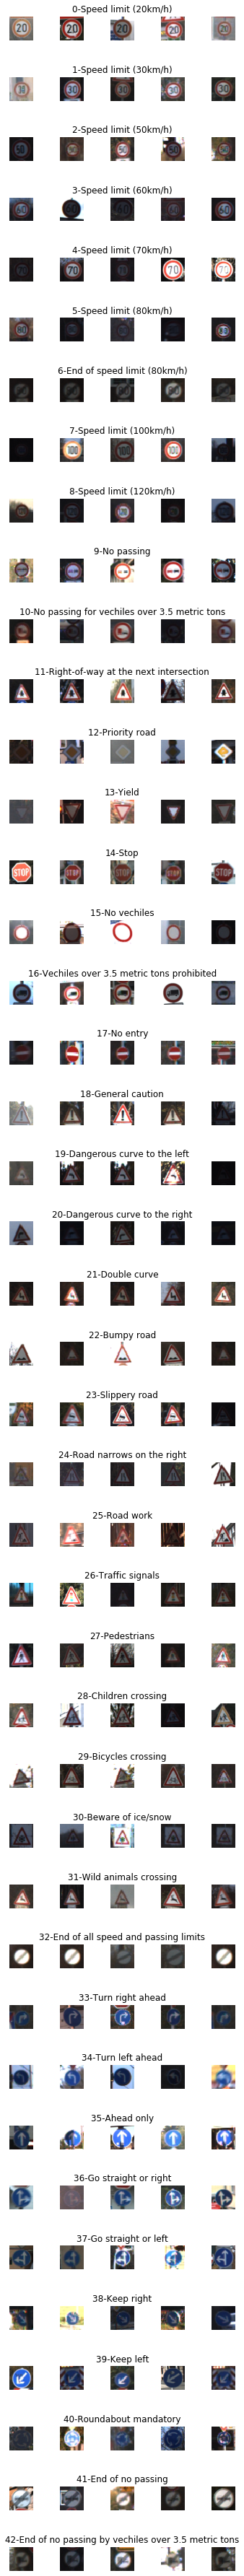

In [0]:
num_of_samples = []
cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize = (5, 50))
fig.tight_layout()

for i in range(cols):
  for j, row in data.iterrows():
    x_selected = X_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected) - 1)), :, :], cmap = plt.get_cmap('gray'))
    axs[j][i].axis("off")

    if i == 2:
      axs[j][i].set_title(str(j) + "-" + row["SignName"])
      num_of_samples.append(len(x_selected))


[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


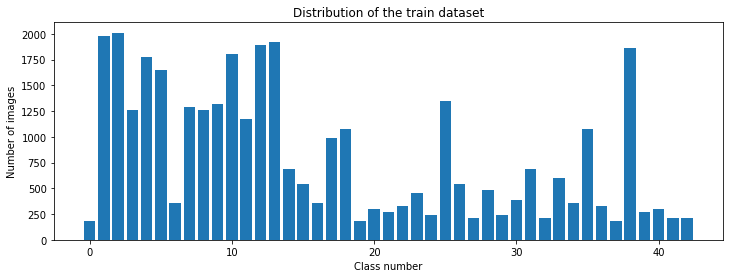

In [0]:
print(num_of_samples)
plt.figure(figsize = (12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


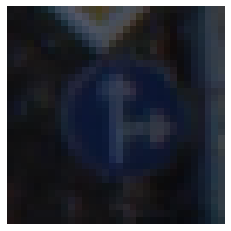

In [0]:
import cv2

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


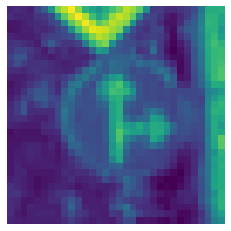

In [0]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


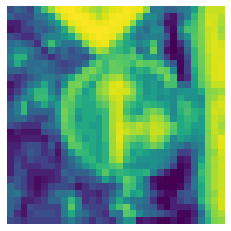

In [0]:
def equalize(img):
  img = cv2.equalizeHist(img) # this will take image that is already grayscale processed
  return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [0]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img / 255
  return img 

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


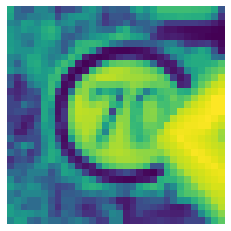

In [0]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis("off")
print(X_train.shape)

In [0]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [0]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [0]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5),  activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  #
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  #
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  # Complie the model
  model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [0]:
model = modified_model()
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 4, 30)         

In [0]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=400, verbose=1, shuffle=1)

Train on 34799 samples, validate on 4410 samples
Epoch 1/10
34799/34799 [==============================] - 368s 11ms/step - loss: 2.4328 - acc: 0.3427 - val_loss: 0.7879 - val_acc: 0.7932
Epoch 2/10
34799/34799 [==============================] - 367s 11ms/step - loss: 0.7398 - acc: 0.7699 - val_loss: 0.3030 - val_acc: 0.9202
Epoch 3/10
34799/34799 [==============================] - 369s 11ms/step - loss: 0.3971 - acc: 0.8763 - val_loss: 0.2050 - val_acc: 0.9422
Epoch 4/10
34799/34799 [==============================] - 368s 11ms/step - loss: 0.2853 - acc: 0.9103 - val_loss: 0.1432 - val_acc: 0.9542
Epoch 5/10
34799/34799 [==============================] - 368s 11ms/step - loss: 0.2285 - acc: 0.9295 - val_loss: 0.1138 - val_acc: 0.9660
Epoch 6/10
34799/34799 [==============================] - 366s 11ms/step - loss: 0.1840 - acc: 0.9424 - val_loss: 0.0916 - val_acc: 0.9705
Epoch 7/10
34799/34799 [==============================] - 368s 11ms/step - loss: 0.1675 - acc: 0.9483 - val_loss: 0.0

Text(0.5, 0, 'epoch')

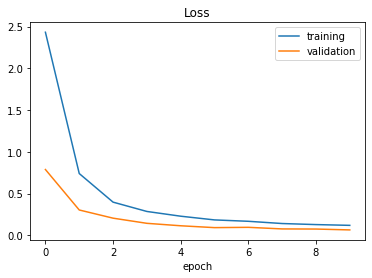

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

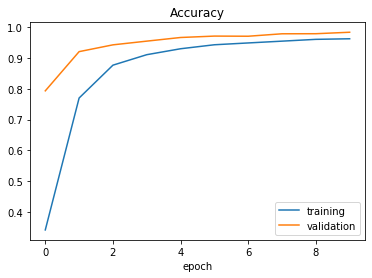

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [0]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: ', score[0])
print('Test Accuracy: ', score[1])

Test Score:  0.14313978128672022
Test Accuracy:  0.9587490103118305


Now we can put our network to real test by evaluating it on a real images off the internet. We will try a variety of images and see if our network can classify them correctly.
We will require the following image links in order to test your neural network:
•	https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg
label 1
•	https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg
lable 34
•	https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg
label 23
•	https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg 
label 13
•	https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg
label 29


In [0]:
import requests
from PIL import Image
# url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

We will preprocessed the image the same way we preprocessed all of our  other images will. The only difference here from imnest how we did it in imnest is that instead of resizing it to a 28x28 we are resizing it to be 32x32 since we trained our NN on 32x32 images, so it is only fitting that we test our own NN on images of the same size. We still need to preprocess the test image the same way we preprocessed all our other images to ensure consistency. Thus calling the previously defined preprocessing function and we still need to reshape the image to have the appropriate depth before being fed into the NN. And reshaping image to have the appropriate depth and to actually feed the image into a NN. We have already made use of model.predict class, we simply predict the class to which our image most likely belongs.

In [0]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [0]:
img = img.reshape(1, 32, 32, 1)

In [0]:
print("predicted sign: "+ str(model.predict_classes(img)))

We start by tesing the image of a speed limitsign which limits the max speed of 30 km per hour which means that it belongs to the class labeled one.
It seems that our model was successful in classifying this random image.

After running all the sample image, our model is not performing up to standard despite interducing modifications to our our model, we have still not hit a high accuracy for effective traffic on classification. This is the result of a more complex dataset. and inorder to take our models performance to the next level we are going to introduce one more technique for improving the model training process.